In [1]:
#-----import packages-----#

#common python packages
import numpy as np
import string
import random
import os
import pickle
import argparse
import wget
import math
import gc
import matplotlib.pyplot as plt
from datetime import datetime
from tempfile import TemporaryFile

#biological packages
import pybedtools
from pybedtools import featurefuncs
import pyBigWig

#machine learning packages
import sklearn
from sklearn import metrics
from sklearn.utils import shuffle, class_weight
from matplotlib import pyplot as plt
import pandas as pd

import tensorflow as tf

import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, GlobalAveragePooling2D, Multiply
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras.utils import Sequence, plot_model
from keras.constraints import unit_norm
from keras import regularizers
from keras.callbacks import EarlyStopping, Callback, TensorBoard, ReduceLROnPlateau
import keras_metrics as km
from keras.models import load_model

from models.v9 import create_model
from models.custom_metrics import auroc, auprc, recall_m, precision_m, f1_m

#notify the OS about GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['KERAS_BACKEND'] = 'tensorflow'

Using TensorFlow backend.


In [2]:
#parsing command line arguments
# -----parsing command line arguments-----#
parser = argparse.ArgumentParser(description='Training CNN model to predict STARR-seq enhancers based on chromatin accessbility and histone marks')
parser.add_argument('-c', '--cell_types', type=str, help='comma separated string of cell_types')
parser.add_argument('-i', '--in_dir', type=str, help='directory containing 01_data_encoding intermediate tsv files')

#simulate command line input
cmdline_str='-c ' + " HepG2,K562 " + \
    ' -i ' + "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/encoded_2overlap/ATAC/"

seq_names = ["ATAC", "H3K27ac", "H3K4me3", "H3K9ac", "H3K4me1"]

#check if the files are there
args = parser.parse_args(cmdline_str.split())
args.cell_types = args.cell_types.split(",")
for cell in args.cell_types:
    for seq in seq_names:
        pos_file = args.in_dir + cell + "." + seq + ".pos.tsv"
        if not os.path.exists(pos_file):
            print(pos_file + " file does not exist")
            exit(1)
        neg_file = args.in_dir + cell + "." + seq + ".neg.tsv"
        if not os.path.exists(neg_file):
            print(neg_file + " file does not exist")
            exit(1)
print("all files found!")

all files found!


In [3]:
with open(args.in_dir + "hg38_signals.pickle", 'rb') as f:
    X, Y = pickle.load(f)
window_size = int(X.shape[2] * 10)
X = X[:,[1,2,0,3,4],:] # move ATAC-seq to the middle
X, Y = shuffle(X, Y, random_state=0)
x_train = np.expand_dims(X, axis=4)
y_train = Y

#calculate class weights
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y_train),
                                                  y_train.flatten())

/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


In [4]:
# construct the model
model = create_model(width=int(window_size/10))
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
adam = Adam(lr=5e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=9e-5)
model.compile(loss='binary_crossentropy', optimizer=adam, 
    metrics=['accuracy', auroc, auprc, f1_m, recall_m, precision_m])

if os.path.exists('./saved_models/ATAC_hg38.v9.h5'):
    model.load_weights('./saved_models/ATAC_hg38.v9.h5')
else:
    #train the model
    history = model.fit(x_train, y_train,
                        batch_size=32,
                        epochs=100,
                        validation_split=0.1,
                        shuffle=True,
                        class_weight=class_weights,
                        callbacks=[es]) 

    model.save_weights('./saved_models/ATAC_hg38.v9.h5')

/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/models/v9.py:54: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  model = Model(input=[input_size], output=[pred_output])


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5, 400, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1, 391, 128)  6528        input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 128)          0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 8)            1032        global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
dense_2 (D

In [5]:
with open("./mm10/mm10_all_signals.pickle", 'rb') as f:
    X,Y = pickle.load(f)
samples = ["forebrain", "heart", "hindbrain", "limb", "midbrain", "neural tube"]
for i in range(len(samples)):
    X[i][:, [0, 2], :] = X[i][:, [2, 0], :]

In [6]:
y_pred_list = []
accuracy_list = []
for i in range(len(samples)):
    y_pred = model.predict(X[i]).ravel()
    y_pred_list.append(y_pred)

    accuracy_s = sklearn.metrics.accuracy_score(Y[i], np.rint(y_pred))
    print(samples[i], "validation accuracy is:", accuracy_s)
    accuracy_list.append(accuracy_s)

forebrain validation accuracy is: 0.7962392108508015
heart validation accuracy is: 0.8202836004932182
hindbrain validation accuracy is: 0.8329223181257707
limb validation accuracy is: 0.8329223181257707
midbrain validation accuracy is: 0.8261405672009864
neural tube validation accuracy is: 0.8551171393341553


6 101 101


/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


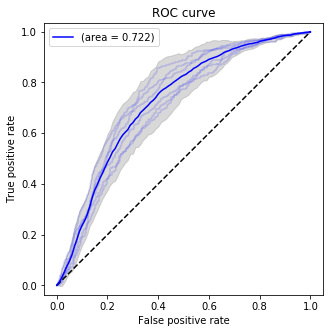

In [7]:
# ROC in test set
plt.figure(figsize=(5, 5))
base_fpr = np.linspace(0, 1, 101)
tpr_list = []
auroc_list = []
for i in range(len(Y)):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(Y[i], y_pred_list[i])
    auroc_list.append(sklearn.metrics.roc_auc_score(Y[i], y_pred_list[i]))
    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tpr_list.append(tpr)

print(len(tpr_list), len(tpr_list[0]), len(tpr_list[1]))
tpr_list = np.array(tpr_list)
mean_tpr = np.mean(np.array(tpr_list), axis=0)
tpr_std = tpr_list.std(axis=0)

tprs_upper = np.minimum(mean_tpr + 2 * tpr_std, 1)
tprs_lower = mean_tpr - 2 * tpr_std

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(base_fpr, mean_tpr, 'b', label='(area = {:.3f})'.format(np.mean(np.array(auroc_list))))
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.axes().set_aspect('equal', 'datalim')
#plt.savefig(figure_output_name+'.ROC.png')

6 101 101


/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


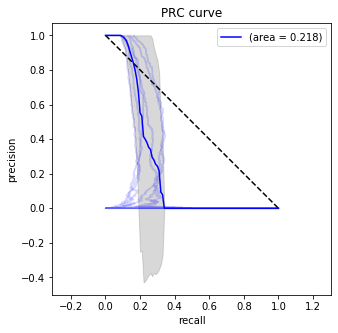

In [8]:
# PRC in test set
plt.figure(figsize=(5, 5))
base_recall = np.linspace(0, 1, 101)
precision_list = []
auprc_list = []
for i in range(len(Y)):
    recall, precision, thresholds = sklearn.metrics.precision_recall_curve(Y[i], y_pred_list[i])
    auprc_list.append(sklearn.metrics.average_precision_score(Y[i], y_pred_list[i]))
    plt.plot(recall, precision, 'b', alpha=0.15)
    precision = np.interp(base_recall, recall, precision)
    precision[0] = 1.0
    precision_list.append(precision)

print(len(precision_list), len(precision_list[0]), len(precision_list[1]))
precision_list = np.array(precision_list)
mean_precision = np.mean(np.array(precision_list), axis=0)
precision_std = precision_list.std(axis=0)

precisions_upper = np.minimum(mean_precision + 2 * precision_std, 1)
precisions_lower = mean_precision - 2 * precision_std

plt.plot([0, 1], [1, 0], 'k--')
plt.plot(base_recall, mean_precision, 'b', label='(area = {:.3f})'.format(np.mean(np.array(auprc_list))))
plt.fill_between(base_recall, precisions_lower, precisions_upper, color='grey', alpha=0.3)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('PRC curve')
plt.legend(loc='best')
plt.axes().set_aspect('equal', 'datalim')
#plt.savefig(figure_output_name+'.PRC.png')

In [9]:
for i in range(len(samples)):
    print("validated tissue " + samples[i] + " auROC: " + str(auroc_list[i]))
    
print("\n")

for i in range(len(samples)):
    print("validated tissue " + samples[i] + " auPRC: " + str(auprc_list[i]))

validated tissue forebrain auROC: 0.740619036259542
validated tissue heart auROC: 0.7479263197255687
validated tissue hindbrain auROC: 0.7112503256815315
validated tissue limb auROC: 0.6818967501746364
validated tissue midbrain auROC: 0.7576078031989643
validated tissue neural tube auROC: 0.6938701465550058


validated tissue forebrain auPRC: 0.29216263731125675
validated tissue heart auPRC: 0.18065540506499708
validated tissue hindbrain auPRC: 0.23843427024824004
validated tissue limb auPRC: 0.1698154122504809
validated tissue midbrain auPRC: 0.27795502326874644
validated tissue neural tube auPRC: 0.1518228867690241


In [10]:
y_pred_list = []
accuracy_list = []
for i in range(len(samples)):
    
    #fine-tuning
    X_ft = X.copy()
    X_ft.pop(i)
    X_ft = np.array(X_ft)
    X_ft = X_ft.reshape((-1, X_ft.shape[2], X_ft.shape[3], X_ft.shape[4]))
    
    Y_ft = Y.copy()
    Y_ft.pop(i)
    Y_ft = np.array(Y_ft)
    Y_ft = Y_ft.reshape((-1, 1))
    
    X_ft, Y_ft = shuffle(X_ft, Y_ft, random_state=0)
    
    class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(Y_ft),
                                                  Y_ft.flatten())
    
    es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    ft_model = create_model(width=int(window_size/10))
    ft_model.load_weights('./saved_models/ATAC_hg38.v9.h5')
    ft_model.compile(loss='binary_crossentropy', 
                     optimizer=Adam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=9e-5), 
                     metrics=['accuracy', auroc, auprc, f1_m, recall_m, precision_m])
    
    #train the model
    history = ft_model.fit(X_ft, Y_ft,
                        batch_size=4,
                        epochs=150,
                        validation_split=0.1,
                        shuffle=True,
                        class_weight=class_weights,
                        callbacks=[es])
    
    y_pred = ft_model.predict(X[i]).ravel()
    y_pred_list.append(y_pred)

    accuracy_s = sklearn.metrics.accuracy_score(Y[i], np.rint(y_pred))
    print(samples[i], "validation accuracy is:", accuracy_s)
    accuracy_list.append(accuracy_s)

/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/models/v9.py:54: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  model = Model(input=[input_size], output=[pred_output])


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5, 400, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1, 391, 128)  6528        input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 128)          0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 8)            1032        global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
dense_2 (D

6 101 101


/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


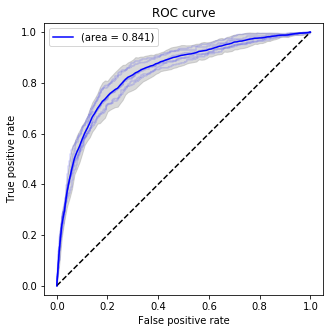

In [11]:
# ROC in test set
plt.figure(figsize=(5, 5))
base_fpr = np.linspace(0, 1, 101)
tpr_list = []
auroc_list = []
for i in range(len(Y)):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(Y[i], y_pred_list[i])
    auroc_list.append(sklearn.metrics.roc_auc_score(Y[i], y_pred_list[i]))
    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tpr_list.append(tpr)

print(len(tpr_list), len(tpr_list[0]), len(tpr_list[1]))
tpr_list = np.array(tpr_list)
mean_tpr = np.mean(np.array(tpr_list), axis=0)
tpr_std = tpr_list.std(axis=0)

tprs_upper = np.minimum(mean_tpr + 2 * tpr_std, 1)
tprs_lower = mean_tpr - 2 * tpr_std

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(base_fpr, mean_tpr, 'b', label='(area = {:.3f})'.format(np.mean(np.array(auroc_list))))
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.axes().set_aspect('equal', 'datalim')
#plt.savefig(figure_output_name+'.ROC.png')

6 101 101


/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


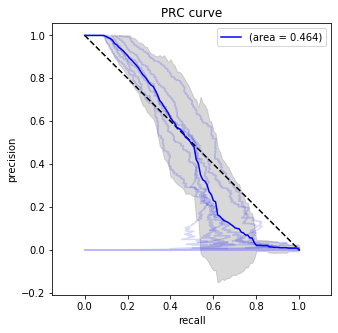

In [12]:
# PRC in test set
plt.figure(figsize=(5, 5))
base_recall = np.linspace(0, 1, 101)
precision_list = []
auprc_list = []
for i in range(len(Y)):
    recall, precision, thresholds = sklearn.metrics.precision_recall_curve(Y[i], y_pred_list[i])
    auprc_list.append(sklearn.metrics.average_precision_score(Y[i], y_pred_list[i]))
    plt.plot(recall, precision, 'b', alpha=0.15)
    precision = np.interp(base_recall, recall, precision)
    precision[0] = 1.0
    precision_list.append(precision)

print(len(precision_list), len(precision_list[0]), len(precision_list[1]))
precision_list = np.array(precision_list)
mean_precision = np.mean(np.array(precision_list), axis=0)
precision_std = precision_list.std(axis=0)

precisions_upper = np.minimum(mean_precision + 2 * precision_std, 1)
precisions_lower = mean_precision - 2 * precision_std

plt.plot([0, 1], [1, 0], 'k--')
plt.plot(base_recall, mean_precision, 'b', label='(area = {:.3f})'.format(np.mean(np.array(auprc_list))))
plt.fill_between(base_recall, precisions_lower, precisions_upper, color='grey', alpha=0.3)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('PRC curve')
plt.legend(loc='best')
plt.axes().set_aspect('equal', 'datalim')
#plt.savefig(figure_output_name+'.PRC.png')

In [13]:
for i in range(len(samples)):
    print("validated tissue " + samples[i] + " auROC: " + str(auroc_list[i]))
print("overall auROC average " + str(np.mean(auroc_list)))
    
print("\n")

for i in range(len(samples)):
    print("validated tissue " + samples[i] + " auPRC: " + str(auprc_list[i]))
print("overall auPRC average " + str(np.mean(auprc_list)))

validated tissue forebrain auROC: 0.8653390912662775
validated tissue heart auROC: 0.8629880722062354
validated tissue hindbrain auROC: 0.8209612918929297
validated tissue limb auROC: 0.8255451435194006
validated tissue midbrain auROC: 0.8410311370059843
validated tissue neural tube auROC: 0.8318685763228016
overall auROC average 0.8412888853689383


validated tissue forebrain auPRC: 0.5772900703733563
validated tissue heart auPRC: 0.43578481181306494
validated tissue hindbrain auPRC: 0.4588703969674074
validated tissue limb auPRC: 0.41890523348605707
validated tissue midbrain auPRC: 0.5212955107035343
validated tissue neural tube auPRC: 0.37459150272144615
overall auPRC average 0.46445625434414434
